<a href="https://colab.research.google.com/github/HoangHungLN/MachineLearning_Assigment/blob/main/Assignment2/notebooks/Assignment2_CEML2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
##Xử lý dữ liệu

#Import thư viện
import re, regex as re2, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import os
from scipy import sparse
from IPython.display import display
plt.style.use("seaborn-v0_8"); sns.set_palette("Set2")  #Định dạng bảng

os.makedirs("modules", exist_ok= True)
!wget https://raw.githubusercontent.com/HoangHungLN/MachineLearning_Assigment/refs/heads/main/Assignment2/modules/features_extractor.py -O modules/features_extractor.py
!wget https://raw.githubusercontent.com/HoangHungLN/MachineLearning_Assigment/refs/heads/main/Assignment2/modules/tfidf_glove.py -O modules/tfidf_glove.py
os.makedirs("features/tfidf_glove", exist_ok= True)
!wget https://github.com/HoangHungLN/MachineLearning_Assigment/raw/refs/heads/main/Assignment2/features/tfidf_glove/Xte_w2v.npy -O features/tfidf_glove/Xte_w2v.npy
!wget https://github.com/HoangHungLN/MachineLearning_Assigment/raw/refs/heads/main/Assignment2/features/tfidf_glove/Xtr_w2v.npy -O features/tfidf_glove/Xtr_w2v.npy
!wget https://github.com/HoangHungLN/MachineLearning_Assigment/raw/refs/heads/main/Assignment2/features/tfidf_glove/Xva_w2v.npy -O features/tfidf_glove/Xva_w2v.npy
#Tải dữ liệu bảng CSV từ github
dataset_url = "https://raw.githubusercontent.com/HoangHungLN/MachineLearning_Assigment/refs/heads/main/Assignment2/data/all_tickets_processed_improved_v3.csv"
raw_data = pd.read_csv(dataset_url)
raw_data = raw_data.replace({r'â€‰':'', r'\u2009':''}, regex=True)  #Làm sạch dữ liệu

#In thử 5 dòng đầu
raw_data.head(5)

--2025-10-07 18:23:20--  https://raw.githubusercontent.com/HoangHungLN/MachineLearning_Assigment/refs/heads/main/Assignment2/modules/features_extractor.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4814 (4.7K) [text/plain]
Saving to: ‘modules/features_extractor.py’

modules/features_ex 100%[===================>]   4.70K  --.-KB/s    in 0s      

2025-10-07 18:23:20 (48.2 MB/s) - ‘modules/features_extractor.py’ saved [4814/4814]

--2025-10-07 18:23:20--  https://raw.githubusercontent.com/HoangHungLN/MachineLearning_Assigment/refs/heads/main/Assignment2/modules/tfidf_glove.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubuserconte

,Document,Topic_group
0,connection with icon icon dear please setup ic...,Hardware
1,work experience user work experience user hi w...,Access
2,requesting for meeting requesting meeting hi p...,Hardware
3,reset passwords for external accounts re expir...,Access
4,mail verification warning hi has got attached ...,Miscellaneous


In [2]:
#Kiểm tra số lượng mẫu và thuộc tính gốc của dữ liệu
print ("Số lượng mẫu có trong dataset là:", raw_data.shape[0])
print ("Số lượng thuộc tính có trong dataset là:", raw_data.shape[1])

Số lượng mẫu có trong dataset là: 47837
Số lượng thuộc tính có trong dataset là: 2


Document       0
Topic_group    0
dtype: int64
Duplicates: 0
text_col: Document label_col: Topic_group


,count
Topic_group,
Hardware,13617
HR Support,10915
Access,7125
Miscellaneous,7060
Storage,2777


count    47837.000000
mean        43.597341
std         56.736800
min          2.000000
25%         17.000000
50%         26.000000
75%         46.000000
max        981.000000
Name: Document, dtype: float64


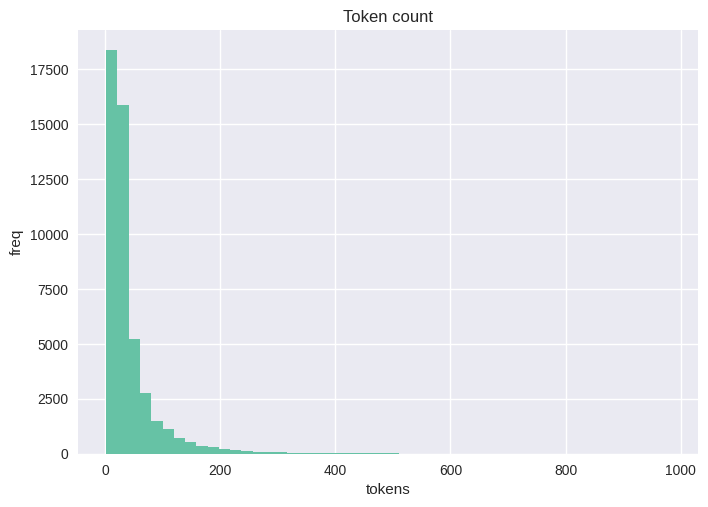

In [3]:
# Kiểm tra dữ liệu null và trùng lặp
print(raw_data.isna().sum().sort_values(ascending=False).head())
print("Duplicates:", raw_data.duplicated().sum())

# Xác định cột văn bản và cột nhãn
obj_cols = [c for c in raw_data.columns if raw_data[c].dtype=='object']
text_col = max(obj_cols, key=lambda c: raw_data[c].astype(str).str.len().mean())
label_col = [c for c in raw_data.columns if c != text_col][0]  # dataset có 2 cột

print("text_col:", text_col, "label_col:", label_col)

# Thống kê phân phối nhãn
vc = raw_data[label_col].value_counts()
display(vc.head()); (vc/vc.sum()).head()

# Thống kê độ dài văn bản
lens = raw_data[text_col].astype(str).str.split().map(len)
print(lens.describe())
plt.figure(); lens.hist(bins=50); plt.title('Token count'); plt.xlabel('tokens'); plt.ylabel('freq'); plt.show()

# Đề xuất max_len và vocab_limit
max_len = int(np.percentile(lens, 95))  # gợi ý
vocab_limit = 30000

**Nhận xét về dữ liệu**

*Tính sạch của dữ liệu*

- Không có giá trị bị thiếu (NaN).

- Không có dòng trùng lặp.

-> Dữ liệu gốc rất sạch, không cần xử lý thiếu/trùng.

*Cột dữ liệu*

- Document: cột chứa văn bản (mô tả sự cố IT).

- Topic_group: cột nhãn phân loại (loại sự cố).

*Phân phối nhãn*

- 5 nhóm chính:

- Hardware: 13,617 mẫu

- HR Support: 10,915 mẫu

- Access: 7,125 mẫu

- Miscellaneous: 7,060 mẫu

- Storage: 2,777 mẫu

-> Các nhãn hơi mất cân bằng: Hardware nhiều gấp gần 5 lần Storage.
Cần lưu ý khi huấn luyện mô hình (có thể dùng class weights).

*Độ dài văn bản*

- Trung bình: ~44 từ.

- Median (50% dữ liệu): 26 từ.

- 75% dữ liệu: ≤ 46 từ.

- Văn bản dài nhất: 981 từ.

-> Biểu đồ histogram cho thấy đa số văn bản rất ngắn (<50 từ), chỉ một số ít cực dài → phân phối lệch phải (skewed).

*Tham số tiền xử lý đề xuất*

- max_len = ~120 (percentile 95) -> đủ bao phủ 95% dữ liệu, tránh bị outlier kéo dài.

- vocab_limit = 30,000 -> giới hạn từ vựng cho tokenizer, cân bằng giữa hiệu quả và tài nguyên.

In [4]:
#Chia train 80%, test 10%, validation 10%
from sklearn.model_selection import train_test_split
train, test = train_test_split(raw_data, test_size=0.1, stratify=raw_data[label_col], random_state=42)
train, val  = train_test_split(train,    test_size=0.1, stratify=train[label_col],    random_state=42)

In [5]:
import re
import pandas as pd

# Gộp toàn bộ dữ liệu (nếu bạn có train / val / test)
all_text = pd.concat([train[text_col], val[text_col], test[text_col]], ignore_index=True)

# Regex: tìm ký tự KHÔNG phải chữ (A-Z a-z) và KHÔNG phải số (0-9)
pattern = re.compile(r"[^A-Za-z0-9]")

# Dòng nào chứa ký tự không phải chữ/số
mask = all_text.str.contains(pattern)

# Thống kê
count_special = mask.sum()
total = len(all_text)

print(f"Số dòng chứa ký tự không phải chữ/số: {count_special}/{total} ({count_special/total:.2%})")

# In vài ví dụ
print("\nVí dụ các dòng có ký tự không phải chữ/số:")
print(all_text[mask].sample(min(10, count_special), random_state=42).tolist())

Số dòng chứa ký tự không phải chữ/số: 47837/47837 (100.00%)

Ví dụ các dòng có ký tự không phải chữ/số:
['oracle task list malfunction task list malfunction hello task list does remove task when complete still appears have items review action upon same upper right hand corner thank you unit manager', 'outlook calendar issue calendar hi when click scheduling tab within meeting invite able anyone calendars know if available attend meetings can you please fix for going for over week please attached thank you advertising', 'please remove access for from please hi please best regards design lead', 'new project code request thursday november pm re code please thursday november pm code hi raised requested please let needs created well thank kind regards analyst ext hub thursday november pm code good morning please attached thanks officer', 'check if access to is still needed tuesday pm re devices hi apologies thought had replied remember looking approved requester how required duration disabl

In [6]:
#Import thư viện
!pip -q install emoji unidecode
import nltk; nltk.download('stopwords')
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sk_sw
from nltk.corpus import stopwords
from emoji import replace_emoji
from unidecode import unidecode
import unicodedata
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
std_english_stop = set(stopwords.words('english')) | set(sk_sw)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 9.5 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:

import numpy as np
from typing import List, Tuple, Dict, Any, Set
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

def mine_stopwords_topPct_coef(
    corpus: List[str],           # TRAIN texts (đã clean sơ bộ, CHƯA remove stopwords)
    y: np.ndarray,               # TRAIN labels
    *,
    ngram_range: Tuple[int,int]=(1,2),
    min_df: int|float=2,         # bỏ token quá hiếm khi vectorize
    top_pct: float=0.10,         # lấy Top-X% DF làm candidate (vd 0.10 = 10%)
    lowercase: bool=False,
    use_binary: bool=True,       # dùng X>0 cho LR để tránh thiên lệch do lặp
    class_weight: str|dict="balanced",
    max_iter: int=300,
    # chọn “gần 0” theo 1 trong 2 cách:
    mode: str="frac",            # 'frac' | 'eps'
    bottom_frac: float=0.05,     # nếu mode='frac': lấy bottom 5% theo |coef|
    eps: float=1e-2,             # nếu mode='eps' : chọn |coef| <= eps
    verbose: bool=True
) -> Dict[str, Any]:
    """
    1) Chọn Top-X% token theo DF làm candidate.
    2) Train LogisticRegression(class_weight='balanced') trên tập candidate.
    3) Lọc các token có |coef| ≈ 0 => stopwords domain.

    Trả về: {'stopwords', 'vocab', 'candidates', 'coef_abs', 'top_idx', 'df'}
    """
    # ----- Vectorize toàn bộ (để tính DF) -----
    vec = CountVectorizer(ngram_range=ngram_range, min_df=min_df,
                          lowercase=lowercase, stop_words=None)
    X = vec.fit_transform(corpus)                      # sparse [n_samples, n_features]
    vocab = vec.get_feature_names_out()
    n_docs = X.shape[0]
    df = (X > 0).sum(axis=0).A1

    # ----- Top-X% theo DF làm candidates -----
    m = len(vocab)
    k = max(1, int(top_pct * m))
    order = df.argsort()[::-1]                        # desc DF
    top_idx = order[:k]
    cand_vocab = vocab[top_idx]

    # ----- Ma trận cho LR -----
    Xc = X[:, top_idx]
    if use_binary:
        Xc = (Xc > 0).astype(int)                     # binary presence

    # ----- Train LR (balanced) -----
    clf = LogisticRegression(
        class_weight=class_weight,
        max_iter=max_iter,
        n_jobs=None if hasattr(LogisticRegression(), "n_jobs") else None
    )
    clf.fit(Xc, y)

    # Lấy |coef| (n_classes x k) -> trung bình theo lớp
    coef_abs = np.abs(clf.coef_).mean(axis=0)         # shape (k,)

    # ----- Chọn “gần 0” -----
    if mode == "frac":
        bw = max(1, int(bottom_frac * len(coef_abs))) # bottom k%
        weak_local_idx = np.argsort(coef_abs)[:bw]
        stopwords_auto = set(cand_vocab[weak_local_idx])
    elif mode == "eps":
        weak_local_idx = np.where(coef_abs <= eps)[0]
        stopwords_auto = set(cand_vocab[weak_local_idx])
    else:
        raise ValueError("mode phải là 'frac' hoặc 'eps'.")

    if verbose:
        print(f"[INFO] vocab={m:,}, X={X.shape}, nnz={X.nnz:,}")
        print(f"[INFO] candidates (Top {int(top_pct*100)}% DF) = {len(cand_vocab):,}")
        if mode == "frac":
            print(f"[INFO] stopwords (|coef| bottom {int(bottom_frac*100)}%) = {len(stopwords_auto):,}")
        else:
            print(f"[INFO] stopwords (|coef| <= {eps}) = {len(stopwords_auto):,}")
        # Ví dụ vài từ “gần 0”
        ex = sorted(list(stopwords_auto))[:30]
        print("[SAMPLE]", ex)

    return {
        "stopwords": stopwords_auto,
        "vocab": vocab,
        "candidates": cand_vocab,
        "coef_abs": coef_abs,     # |coef| tương ứng với cand_vocab
        "top_idx": top_idx,
        "df": df
    }

In [8]:
import re

def normalize_stopset(stopset):
    out = set()
    for t in stopset:
        if not isinstance(t, str):
            continue
        t = t.strip().lower()
        if not t:
            continue
        # tách theo khoảng trắng, chỉ giữ token chữ/số (đã clean lowercase từ trước)
        parts = re.findall(r"\w+", t)
        out.update(parts)
    return out

In [9]:
class TextPreprocessor:
    def __init__(self, lower=True, strip_accents=False,
                 remove_urls=True, remove_emojis=True,
                 remove_special=True, remove_numbers=False,
                 remove_stopwords=True, stopwords=None,
                 max_words=30000, max_len=128, oov_token='<OOV>'):
        # Thiết lập tham số tiền xử lý
        self.lower = lower
        self.strip_accents = strip_accents
        self.remove_urls = remove_urls
        self.remove_emojis = remove_emojis
        self.remove_special = remove_special
        self.remove_numbers = remove_numbers
        self.remove_stopwords = remove_stopwords
        # stopwords: set các token đã chuẩn hóa lowercase
        self.stop = set(stopwords) if stopwords else set()

        # Tokenizer để biến từ thành số
        self.tok = Tokenizer(num_words=max_words, oov_token=oov_token)
        self.max_len = max_len

    def _clean(self, s):
        # Làm sạch 1 câu văn bản
        if not isinstance(s, str):
            # ép kiểu an toàn nếu lỡ là bytes/number
            try:
                s = s.decode('utf-8', errors='ignore')
            except Exception:
                s = str(s)

        # Chuẩn hóa Unicode + loại một số zero-width phổ biến
        s = unicodedata.normalize('NFKC', s)
        s = s.replace('\u2009', '').replace('\u200b', '')

        if self.lower:
            s = s.lower()
        if self.strip_accents:
            s = unidecode(s)

        # URL / email / mention / hashtag (thay bằng khoảng trắng để tránh dính chữ)
        if self.remove_urls:
            s = re.sub(r'(https?://\S+|www\.\S+|[\w\.-]+@[\w\.-]+\.\w+|@\w+|#\w+)', ' ', s)

        # Emoji → xóa (hoặc thay bằng khoảng trắng)
        if self.remove_emojis:
            s = replace_emoji(s, replace=' ')

        # Loại ký tự đặc biệt, giữ chữ cái (cả tiếng Việt), số và khoảng trắng
        if self.remove_special:
            s = re2.sub(r"[^\p{L}\p{N}\s]", " ", s)

        # Loại số nếu cần
        if self.remove_numbers:
            s = re.sub(r"\d+(\.\d+)?", " ", s)

        # Tokenize đơn giản theo \w+ (UNIDODE) rồi remove stopwords nếu bật
        toks = re.findall(r"\w+", s, flags=re.UNICODE)
        if self.remove_stopwords and self.stop:
            toks = [t for t in toks if t not in self.stop]

        # Ghép lại & chuẩn hóa khoảng trắng
        return " ".join(toks).strip()

    def fit(self, texts):
        # Làm sạch + xây dựng từ điển từ train
        cleaned = [self._clean(t) for t in texts]
        self.tok.fit_on_texts(cleaned)
        return cleaned

    def transform(self, texts):
        # Làm sạch + chuyển văn bản thành số + padding
        cleaned = [self._clean(t) for t in texts]
        seq = self.tok.texts_to_sequences(cleaned)
        pad = pad_sequences(seq, maxlen=self.max_len, padding='post', truncating='post')
        return pad, cleaned

    def fit_transform(self, texts):
        # Kết hợp fit và transform cho tập train
        cleaned = self.fit(texts)
        seq = self.tok.texts_to_sequences(cleaned)
        pad = pad_sequences(seq, maxlen=self.max_len, padding='post', truncating='post')
        return pad, cleaned

In [10]:
# Khởi tạo bộ tiền xử lý với tham số đã chọn
tp_basic = TextPreprocessor(
    lower=True,
    strip_accents=False,
    remove_urls=True,
    remove_emojis=True,
    remove_special=True,
    remove_numbers=True,     # giữ lại số (mã lỗi, version có thể quan trọng)
    remove_stopwords=False,
    stopwords=None,
    max_words=vocab_limit,    # giới hạn từ vựng
    max_len=max_len           # chiều dài chuỗi sau padding
)

# Tiền xử lý văn bản -> chuyển thành chuỗi số đã padding
_,tr_cleaned = tp_basic.fit_transform(train[text_col].astype(str))   # fit trên train
_,va_cleaned = tp_basic.transform(val[text_col].astype(str))         # transform val
_, te_cleaned = tp_basic.transform(test[text_col].astype(str))        # transform test

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
ytr = le.fit_transform(train[label_col])
yva = le.transform(val[label_col])
yte = le.transform(test[label_col])
res = mine_stopwords_topPct_coef(
    corpus=tr_cleaned, y=ytr,
    ngram_range=(1,2),
    min_df=2,
    top_pct=0.005,
    lowercase=False,
    use_binary=True,
    class_weight="balanced",
    max_iter=300,
    mode="frac",         # lấy bottom theo tỉ lệ
    bottom_frac=0.02,    # bottom 5% |coef|
    verbose=True
)

DOMAIN_STOP_AUTO = normalize_stopset(res["stopwords"])
FINAL_STOPWORDS = (DOMAIN_STOP_AUTO) | std_english_stop

tp = TextPreprocessor(
    lower=True, strip_accents=False,
    remove_urls=True, remove_emojis=True,
    remove_special=True, remove_numbers=True,
    remove_stopwords=True,
    stopwords=FINAL_STOPWORDS
)
_, tr_clean = tp.fit_transform(train[text_col].astype(str))
_, va_clean = tp.transform(val[text_col].astype(str))
_, te_clean = tp.transform(test[text_col].astype(str))


[INFO] vocab=146,485, X=(38747, 146485), nnz=2,323,896
[INFO] candidates (Top 0% DF) = 732
[INFO] stopwords (|coef| bottom 2%) = 14
[SAMPLE] ['about', 'ask', 'dear', 'each subsidiaries', 'for', 'friday', 'march', 'new purchase', 'number whose', 'registered old', 'same', 'street kingdom', 'the', 'whose registered']


In [11]:
print("Số lượng stopwords domain:", len(DOMAIN_STOP_AUTO))
print("Một vài stopwords domain:", list(sorted(DOMAIN_STOP_AUTO))[:30])
print("Tổng Số lượng stopwords:", len(FINAL_STOPWORDS))
print("Một vài stopwords:", list(sorted(FINAL_STOPWORDS))[:30])

Số lượng stopwords domain: 18
Một vài stopwords domain: ['about', 'ask', 'dear', 'each', 'for', 'friday', 'kingdom', 'march', 'new', 'number', 'old', 'purchase', 'registered', 'same', 'street', 'subsidiaries', 'the', 'whose']
Tổng Số lượng stopwords: 409
Một vài stopwords: ['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'ain', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amoungst', 'amount', 'an', 'and', 'another', 'any', 'anyhow', 'anyone', 'anything', 'anyway']


In [12]:
s = train[text_col].iloc[0]         # lấy 1 văn bản gốc từ tập train
_, c = tp.transform([s])            # tiền xử lý văn bản
print("RAW:", s)                    # in ra bản gốc
print("CLEAN:", c[0])               # in ra bản đã làm sạch

RAW: stage is catalogue item removed sent friday stage catalogue item removed hello could you please have look stage set catalog item removed cannot be changed could you please amend we resolve request kind regards specialist
CLEAN: stage catalogue item removed sent stage catalogue item removed hello look stage set catalog item removed changed amend resolve request kind regards specialist


In [13]:
# import os, numpy as np
# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# from scipy import sparse
# from joblib import dump

# # --------- (1) CẤU HÌNH / INPUT ----------
# X_train_text = tr_clean
# X_val_text   = va_clean
# X_test_text  = te_clean

# y_train = np.array(ytr)
# y_val   = np.array(yva)
# y_test  = np.array(yte)


# MAX_FEATURES = 5000
# NGRAMS       = (1, 2)
# MIN_DF       = 2

# # --------- Bag of Word ----------
# bow_vectorizer = CountVectorizer(
#     max_features=MAX_FEATURES,
#     ngram_range=NGRAMS,
#     min_df=MIN_DF,
#     max_df= 0.9,
#     lowercase=False, # text đã clean/lower từ trước
#     stop_words = None,
#     tokenizer=None,    # QUAN TRỌNG: không dùng tokenizer tùy biến ở đây
#     preprocessor=None,# QUAN TRỌNG: không dùng preprocessor tùy biến ở đây
#     analyzer="word"          # giữ mặc định word-level
# )

# Xtr_bow = bow_vectorizer.fit_transform(X_train_text)
# Xva_bow = bow_vectorizer.transform(X_val_text)
# Xte_bow = bow_vectorizer.transform(X_test_text)
# vocab_bow = bow_vectorizer.get_feature_names_out()

# # --------- TF - IDF ----------
# tfidf = TfidfVectorizer(
#     max_features=MAX_FEATURES,
#     ngram_range=NGRAMS,
#     min_df=MIN_DF,
#     max_df= 0.9,
#     lowercase=False, # text đã clean/lower từ trước
#     stop_words = None,
#     preprocessor=None,# QUAN TRỌNG: không dùng preprocessor tùy biến ở đây
#     tokenizer=None,    # QUAN TRỌNG: không dùng tokenizer tùy biến ở đây
#     use_idf=True,         # TF-IDF
#     sublinear_tf=True,
#     analyzer="word"          # giữ mặc định word-level
# )
# Xtr_tfidf = tfidf.fit_transform(X_train_text)
# Xva_tfidf = tfidf.transform(X_val_text)
# Xte_tfidf = tfidf.transform(X_test_text)
# vocab_tfidf = tfidf.get_feature_names_out()



# **Features extraction (Trích xuất đặc trưng dữ liệu)**

Ở bước này, nhóm em lựa chọn ba phương pháp trích xuất đặc trưng chính để biểu diễn dữ liệu văn bản:  
1. **BoW (Bag of Words)**  
2. **TF–IDF (Term Frequency – Inverse Document Frequency)**  
3. **TF–IDF Weighted GloVe Embedding** – kết hợp giữa mô hình GloVe và trọng số TF–IDF.  

---

## **Các phương pháp trích xuất đặc trưng**

### BoW (Bag of Words)
Phương pháp BoW biểu diễn mỗi văn bản dưới dạng vector dựa trên **tần suất xuất hiện của từ** trong tập dữ liệu.  
Các từ trong toàn bộ tập văn bản được đưa vào một “từ điển”, và mỗi câu được biến thành một vector chứa số lần xuất hiện của từng từ trong từ điển đó.  
- **Ưu điểm:** Đơn giản, dễ triển khai.  
- **Nhược điểm:** Không nắm bắt được ngữ nghĩa hoặc thứ tự từ.  

**Cấu hình mặc định trong pipeline:**
- `max_features = 5000`  
- `ngram_range = (1, 2)` (sử dụng cả unigram và bigram)  
- `min_df = 2`, `max_df = 0.9` (loại bỏ từ quá hiếm hoặc quá phổ biến)  
- `lowercase = False` (vì dữ liệu đã được chuẩn hóa từ bước preprocessing)  

---

### TF–IDF (Term Frequency – Inverse Document Frequency)
Phương pháp TF–IDF mở rộng từ BoW, gán trọng số cho mỗi từ dựa trên **tần suất xuất hiện trong một văn bản (TF)** và **độ hiếm trong toàn bộ tập dữ liệu (IDF)**.  
Điều này giúp giảm ảnh hưởng của các từ phổ biến và làm nổi bật các từ mang thông tin đặc trưng hơn.  
- **Ưu điểm:** Giúp mô hình chú ý đến các từ quan trọng.  
- **Nhược điểm:** Vẫn chưa nắm bắt được ngữ nghĩa ngữ cảnh của từ.

**Cấu hình trong pipeline:**
- `max_features = 5000`  
- `ngram_range = (1, 2)`  
- `min_df = 2`, `max_df = 0.9`  
- `sublinear_tf = True` (giảm ảnh hưởng từ có tần suất quá cao)  
- `use_idf = True` (kích hoạt trọng số nghịch đảo IDF)  

---

### TF–IDF Weighted GloVe Embedding
Phương pháp này kết hợp giữa **mô hình nhúng từ GloVe** (Global Vectors for Word Representation) và **trọng số TF–IDF** để tạo biểu diễn câu có ý nghĩa ngữ nghĩa hơn.  

Cụ thể:
1. Mỗi từ trong văn bản được ánh xạ sang vector GloVe (kích thước 300 chiều).  
2. Trọng số TF–IDF được tính cho từng từ.  
3. Vector biểu diễn của câu được tính bằng trung bình có trọng số TF–IDF của các vector từ.


**Cấu hình trong pipeline:**
- Mô hình tiền huấn luyện: 2024 Wikipedia + Gigaword 5 (11.9B tokens, 1.2M vocab, uncased, 300d vectors, 1.6 GB download)[Tải tại đây](https://nlp-stanford-edu.translate.goog/data/wordvecs/glove.2024.wikigiga.300d.zip?_x_tr_sl=en&_x_tr_tl=vi&_x_tr_hl=vi&_x_tr_pto=tc)
- Kích thước vector: `300`  
- Tokenizer: tách từ bằng regex `\w+`  
- Vector câu: trung bình có trọng số TF–IDF  

**Ưu điểm:**  
- Giữ được thông tin ngữ nghĩa của GloVe.  
- Kết hợp được độ quan trọng thống kê của TF–IDF.  

**Chú ý**
- Quá trình tính TF–IDF Weighted GloVe mất nhiều thời gian (~15 phút/lần chạy), nên nhóm em tách phần xử lý này sang file `tfidf_glove.py` và chỉ sử dụng các file đặc trưng `.npy` được trích xuất sẵn từ đợt huấn luyện trong lúc làm bài và lưu trong github nhóm để huấn luyện mô hình.

---

## **Tổng kết**

- Hai phương pháp trích xuất đặc trưng cổ điển **BoW** và **TF–IDF** được triển khai trong file `features_extractor.py`.  
  Các ma trận đặc trưng của hai phương pháp này được lưu dưới dạng file `.npz` để phục vụ cho quá trình huấn luyện và đánh giá mô hình.  
  Hàm `report_vectorizer()` được sử dụng để in ra các thông số cấu hình và thống kê như số chiều đặc trưng, độ thưa (density) và kích thước từ vựng của từng phương pháp.  

- Phương pháp **TF–IDF Weighted GloVe Embedding** được triển khai riêng trong file `tfidf_glove.py`.  
- Do quá trình trích xuất đặc trưng này kết hợp giữa mô hình GloVe kích thước 300 chiều và trọng số TF–IDF nên mất nhiều thời gian xử lý (khoảng 10–15 phút). Vì vậy, nhóm em chỉ thực hiện tính toán một lần duy nhất, sau đó lưu kết quả đặc trưng ra file `.npy` để sử dụng làm đầu vào cho các mô hình huấn luyện sau này.
## **Về `tfidf_glove.py`**

- **Phiên bản thư viện**
  - `scipy == 1.12.*`
  - `gensim == 4.3.2`

- **Bộ vector từ**
  - `glove.2024.wikigiga.300d.zip` tải từ: https://nlp.stanford.edu/data/wordvecs/glove.2024.wikigiga.300d.zip
  - Sử dụng tệp 300 chiều sau khi giải nén; chuyển sang định dạng Word2Vec bằng `glove2word2vec`.

- **Ghi chú triển khai**
  - Tokenization đơn giản theo `\w+` trên văn bản đã được làm sạch.
  - Fit `TfidfVectorizer` trên **train** để lấy IDF; câu vector = trung bình có trọng số **TF × IDF** của các word vectors GloVe.
  - Kết quả đặc trưng được lưu dạng `.npy` tại `features/tfidf_glove/` (train/val/test).

- **Lệnh cài đặt nhanh trong Colab**
  ```bash
  !pip install "scipy==1.12.*" gensim==4.3.2
  !wget "https://nlp.stanford.edu/data/wordvecs/glove.2024.wikigiga.300d.zip"
  !unzip -q glove.2024.wikigiga.300d.zip -d glove.2024.300d

In [14]:
from modules.features_extractor import *
sum_bow = features_extractor_classic(
    tr_clean, va_clean, te_clean,
    mode="BoW",
    max_features=20000,
    ngram_range=(1,2),
    min_df=2,
    max_df=0.9,
)

Xtr_bow = sparse.load_npz("features/bow/Xtr.npz")
Xva_bow = sparse.load_npz("features/bow/Xva.npz")
Xte_bow = sparse.load_npz("features/bow/Xte.npz")
print(sum_bow)

sum_tfidf = features_extractor_classic(
    tr_clean, va_clean, te_clean,
    mode="TFIDF",
    max_features=20000,
    ngram_range=(1,2),
    min_df=2,
    max_df=0.9,
)
Xtr_tfidf = sparse.load_npz("features/tfidf/Xtr.npz")
Xva_tfidf = sparse.load_npz("features/tfidf/Xva.npz")
Xte_tfidf = sparse.load_npz("features/tfidf/Xte.npz")
print(sum_tfidf)



Bag-of-Words Report

>>> Vectorizer params:
  - type: CountVectorizer
  - ngram_range: (1, 2)
  - min_df: 2
  - max_df: 0.9
  - max_features: 20000
  - lowercase: False
  - token_pattern: (?u)\b\w\w+\b
  - use_idf: None
  - sublinear_tf: None
  - stop_words: None
  - vocab_size: 20000

>>> Matrix stats:
  [Train] shape=(38747, 20000)  nnz=1,398,193  density=0.001804
  [Val] shape=(4306, 20000)  nnz=154,848  density=0.001798
  [Test] shape=(4784, 20000)  nnz=171,846  density=0.001796
TF-IDF Report

>>> Vectorizer params:
  - type: TfidfVectorizer
  - ngram_range: (1, 2)
  - min_df: 2
  - max_df: 0.9
  - max_features: 20000
  - lowercase: False
  - token_pattern: (?u)\b\w\w+\b
  - use_idf: True
  - sublinear_tf: True
  - stop_words: None
  - vocab_size: 20000

>>> Matrix stats:
  [Train] shape=(38747, 20000)  nnz=1,398,193  density=0.001804
  [Val] shape=(4306, 20000)  nnz=154,848  density=0.001798
  [Test] shape=(4784, 20000)  nnz=171,846  density=0.001796


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

clf1 = LogisticRegression(max_iter=1000, class_weight='balanced')
clf2 = LogisticRegression(max_iter=1000, class_weight='balanced')
# Huấn luyện trên train
clf1.fit(Xtr_bow, ytr)
clf2.fit(Xtr_tfidf, ytr)

# Dự đoán val/test
yva_pred_tfidf = clf2.predict(Xva_tfidf)
yte_pred_tfidf = clf2.predict(Xte_tfidf)
# Dự đoán val/test
yva_pred_bow = clf1.predict(Xva_bow)
yte_pred_bow = clf1.predict(Xte_bow)

# Đánh giá
print("=== Validation BoW ===")
print("Accuracy:", accuracy_score(yva, yva_pred_bow))
print(classification_report(yva, yva_pred_bow))

print("=== Test BoW===")
print("Accuracy:", accuracy_score(yte, yte_pred_bow))
print(classification_report(yte, yte_pred_bow))

print("=== Validation TF-IDF ===")
print("Accuracy:", accuracy_score(yva, yva_pred_tfidf))
print(classification_report(yva, yva_pred_tfidf))

print("=== Test TF-IDF ===")
print("Accuracy:", accuracy_score(yte, yte_pred_tfidf))
print(classification_report(yte, yte_pred_tfidf))

=== Validation BoW ===
Accuracy: 0.8490478402229448
              precision    recall  f1-score   support

           0       0.89      0.88      0.89       641
           1       0.78      0.78      0.78       158
           2       0.85      0.86      0.86       982
           3       0.86      0.82      0.84      1226
           4       0.81      0.86      0.83       191
           5       0.79      0.84      0.81       636
           6       0.92      0.91      0.91       222
           7       0.87      0.89      0.88       250

    accuracy                           0.85      4306
   macro avg       0.85      0.85      0.85      4306
weighted avg       0.85      0.85      0.85      4306

=== Test BoW===
Accuracy: 0.857232441471572
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       712
           1       0.80      0.84      0.82       176
           2       0.86      0.85      0.86      1092
           3       0.85      0.82   

In [16]:
Xtr_w2v = np.load("features/tfidf_glove/Xtr_w2v.npy")
Xva_w2v = np.load("features/tfidf_glove/Xva_w2v.npy")
Xte_w2v = np.load("features/tfidf_glove/Xte_w2v.npy")

Val acc: 0.7512772875058058
Test acc: 0.7533444816053512
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       712
           1       0.45      0.78      0.57       176
           2       0.83      0.76      0.79      1092
           3       0.80      0.64      0.71      1362
           4       0.64      0.90      0.75       212
           5       0.68      0.72      0.70       706
           6       0.82      0.92      0.87       246
           7       0.75      0.90      0.82       278

    accuracy                           0.75      4784
   macro avg       0.72      0.81      0.75      4784
weighted avg       0.77      0.75      0.75      4784



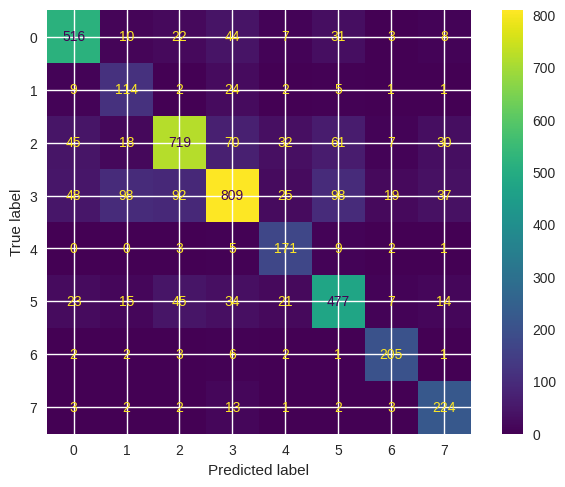

In [17]:
clf3 = LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=-1)
clf3.fit(Xtr_w2v, ytr)

print("Val acc:", accuracy_score(yva, clf3.predict(Xva_w2v)))
print("Test acc:", accuracy_score(yte, clf3.predict(Xte_w2v)))
print(classification_report(yte, clf3.predict(Xte_w2v)))
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(yva, clf3.predict(Xva_w2v))

In [18]:
# def to_tokens(texts):
#     return [t.split() for t in texts]   # vì bạn đã clean theo \w+
# Xtr_tok = to_tokens(tr_clean)
# Xva_tok = to_tokens(va_clean)
# Xte_tok = to_tokens(te_clean)

In [19]:
# !wget https://nlp.stanford.edu/data/wordvecs/glove.2024.wikigiga.300d.zip
# !unzip glove.2024.wikigiga.300d.zip -d glove.2024.300d

In [20]:
# !pip install "scipy==1.12.*"

In [21]:
# !pip install gensim==4.3.2

In [22]:

# from gensim.scripts.glove2word2vec import glove2word2vec
# glove_input_file = "glove.2024.300d/wiki_giga_2024_300_MFT20_vectors_seed_2024_alpha_0.75_eta_0.05_combined.txt"
# w2v_output_file = "glove.2024.300d.w2v.txt"
# glove2word2vec(glove_input_file, w2v_output_file)

In [23]:
# from gensim.models import KeyedVectors
# wv = KeyedVectors.load_word2vec_format("glove.2024.300d.w2v.txt", binary=False)

In [24]:
# from collections import Counter
# tfidf_w2v = TfidfVectorizer(ngram_range=(1,1), min_df=2, max_df=0.9, lowercase= False, sublinear_tf=True, token_pattern= "r[a-z]+")
# tf_w2v = tfidf_w2v.fit(tr_clean)
# idf_map = dict(zip(tf_w2v.get_feature_names_out(), tf_w2v.idf_))

# idf_default = np.median(list(idf_map.values()))

# def sent_vec_tfidf(tokens, keyedvecs):
#     dim = keyedvecs.vector_size
#     cnt = Counter(tokens)               # TF theo token-list của bạn
#     wsum = np.zeros(dim, dtype="float32")
#     wtot = 0.0
#     for t, tf in cnt.items():
#         if t in keyedvecs:
#             idf = idf_map.get(t, idf_default)
#             wt = tf * idf               # TF × IDF
#             wsum += keyedvecs[t] * wt
#             wtot += wt
#     return (wsum / wtot) if wtot > 0 else np.zeros(dim, dtype="float32")

# def docs_to_matrix(token_lists, keyedvecs):
#     dim = keyedvecs.vector_size
#     return np.vstack([sent_vec_tfidf(toks, keyedvecs) for toks in token_lists])


# Xtr_w2v = docs_to_matrix(Xtr_tok, wv)
# Xva_w2v = docs_to_matrix(Xva_tok, wv)
# Xte_w2v = docs_to_matrix(Xte_tok, wv)
